# Otsu Binarization
***
Unlike the other thresholding methods such as binary thresholding where the threshold value is decided by the developer, otsu thresholding determines the best threshold value by minimizing the within class variance. 

After getting the histogram of the grayscale image, Otsu thresholding involves splitting the values into two classes, commonly called the foreground and background. The background will be all values < the threshold value, and the foreground will be all values >= the threshold value. The within class variance is calculated for each threshold value in the desired range. In the following example, I used the range 1 - 255. The index with the lowest within class variance score is used as the threshold value. This threshold value can then be passed in to binary thresholding to threshold the image.

Another way to find the optimal threshold value is to use the maximum betwenn class variance score. I tried to use both methods to try and find the optimal value, but the between class variance differs drastically from the within class variance score. These should yield the same value, but I have yet to figure out why they do not match up.

Please look at the references located at the bottom of these notes for all math performed in the following example.
***
## Setup

In [1]:
# notebook imports 
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# loading in images
flowers = cv2.imread('../Image_Data/flowers.jpg')
flowers = cv2.cvtColor(flowers, cv2.COLOR_BGR2RGB)
gray_flowers = cv2.cvtColor(flowers, cv2.COLOR_RGB2GRAY)

After the image is converted to grayscale, the image histogram needs to be calculated. This can be done as follows:

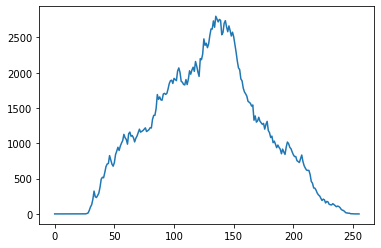

In [69]:
# calculating and showing grayscale image histogram
hist = cv2.calcHist([gray_flowers], [0], None, [256], [0,256])
plt.plot(hist)
plt.show()

***
## Otsu Binarization - Full Code Example

The following two cells contain helper methods for the main otsu threshold method. 

In [99]:
# for calculating mean - not working due to start_idx, just use start idx (fix this!)
# out of range for something, probably the length of the array
def otsu_mean(start_idx, array):
    mean_sum = 0
    arr_sum = np.sum(array)
    if arr_sum == 0:
        return 0
    for i in range(len(array)):
        mean_sum += (i+start_idx) * array[i, 0]
    return mean_sum/arr_sum

In [56]:
# calculating variances for histogram subarries
def otsu_variance(mean, start_idx, array):
    arr_sum = np.sum(array)
    variance = 0
    if arr_sum == 0:
        return 0
    for i in range(len(array)):
        variance += (((i + start_idx) - mean) ** 2) * array[i, 0]
    return variance/arr_sum

Now the optimal threshold value can be calculated. The method below returns the set of values for within class variance and between class variance for threshold values of 1 to 255, and also returns the optimal threshold values for within class and between class variance.

In [62]:
# finding the otsu thresholds calculating from between class and within class variance
# method expects grayscale image
# something might be off about the between class variance, I'm not sure yet though 
def otsu_thresh(img):
    # calculating histogram
    hist = cv2.calcHist([gray_flowers], [0], None, [256], [0,256])
    wcv_list = []
    bcv_list = []
    
    pixl_count = len(gray_flowers) * len(gray_flowers[0])
    max_bet_class_var = 0
    min_within_class_var = 10000000
    thresh_val_wcv = 0
    thresh_val_bcv = 0
    
    for i in range(1, len(hist)):
        # grabbing background and foreground classes based on current threshold
        bg = hist[:i]
        fg = hist[i:]
        
        # calculating fg and bg weights
        w_bg = np.sum(bg)/pixl_count
        w_fg = 1 - w_bg
        
        # taking class means
        mean_bg = otsu_mean(i-1, bg)
        mean_fg = otsu_mean(i, fg)
        
        # taking class variances
        bg_var = otsu_variance(mean_bg, i-1, bg)
        fg_var = otsu_variance(mean_fg, i, fg)
        
        # computing between class variance
        mean_sq_diff = (mean_bg - mean_fg) * (mean_bg - mean_fg)
        bet_class_var = w_bg * w_fg * mean_sq_diff
        bcv_list.append(bet_class_var)
        if (bet_class_var > max_bet_class_var):
            max_bet_class_var = bet_class_var
            thresh_val_bcv = i
        
        # computing within class variance
        within_class_var = bg_var * w_bg + fg_var * w_fg
        wcv_list.append(within_class_var)
        if within_class_var < min_within_class_var:
            min_within_class_var = within_class_var
            thresh_val_wcv = i
            
    return wcv_list, bcv_list, thresh_val_wcv, thresh_val_bcv

In [86]:
# getting and storing results of the otsu_thresh method
wcv_list, bcv_list, thresh_val_wcv, thresh_val_bcv = otsu_thresh(gray_flowers)

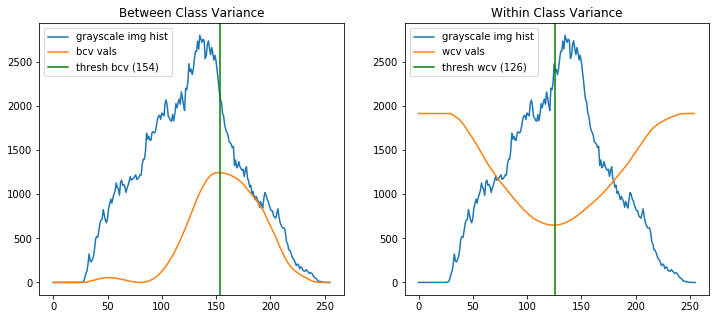

In [94]:
# showing results of otsu thresholding
fig, axarr = plt.subplots(1, 2, figsize=(12, 5))
axarr[0].set_title('Between Class Variance')
axarr[0].plot(hist, label='grayscale img hist')
axarr[0].plot(bcv_list, label='bcv vals')
axarr[0].axvline(thresh_val_bcv, 0, 3000, label='thresh bcv ('+str(thresh_val_bcv)+')', color='green')
axarr[0].legend()

axarr[1].set_title('Within Class Variance')
axarr[1].plot(hist, label='grayscale img hist')
axarr[1].plot(wcv_list, label='wcv vals')
axarr[1].axvline(thresh_val_wcv, 0, 3000, label='thresh wcv ('+str(thresh_val_wcv)+')', color='green')
axarr[1].legend()

As can be seen in the two graphs above, the within class and between class variance ideal threshol values do not match up for some reason. I have yet to determine the cause of this. For the image threshold, the within class variance threshold value is almost identical to the one calculated by opencv.

In [96]:
# using binary thresholding to create binary images using calculated threshold value
ret_wcv,thresh_wcv = cv2.threshold(gray_flowers,thresh_val_wcv,255,cv2.THRESH_BINARY)
ret_bcv,thresh_bcv = cv2.threshold(gray_flowers,thresh_val_bcv,255,cv2.THRESH_BINARY)

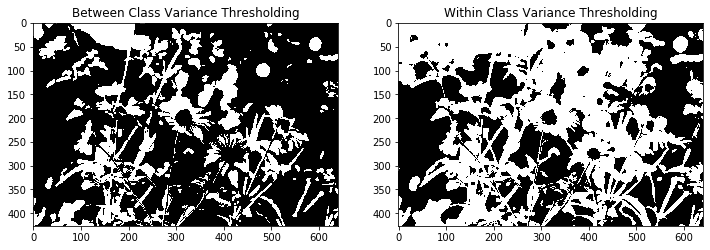

In [98]:
# showing image results
fig2, axarr = plt.subplots(1, 2, figsize=(12, 5))
axarr[0].set_title('Between Class Variance Thresholding')
axarr[0].imshow(thresh_bcv, label='binary img bcv', cmap='gray')
axarr[1].set_title('Within Class Variance Thresholding')
axarr[1].imshow(thresh_wcv, label='binary img wcv', cmap='gray')

The results of applying binary thresholding using the within and between class variance threshold values calculated.

***
## Otsu Binarization - opencv 
In opencv, it does not matter what the initial threshold value that is passed in to the threshold method is. Otsu thresholding will figure out the ideal threshold value, and apply that threshold value to create the resulting binary image. From the example below, the optimal threshold value determined by Otsu thresholding is 125.

125.0

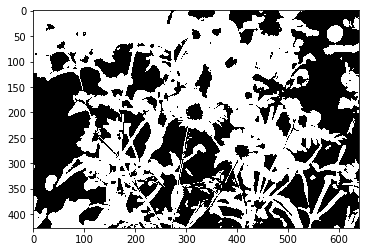

In [30]:
# opencv method
ret,thresh_cv = cv2.threshold(gray_flowers,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(thresh_cv, cmap='gray')
ret

***
## References
* https://en.wikipedia.org/wiki/Otsu%27s_method
* http://www.labbookpages.co.uk/software/imgProc/otsuThreshold.html
***